# Predict name based on first several letters

In [225]:
import torch
import torch.nn.functional as F
import random
import numpy as np
print(f"{torch.cuda.is_available()=}")
device="cpu"
if torch.cuda.is_available():
    device="cuda:0"
print(device)

torch.cuda.is_available()=True
cuda:0


In [226]:
import string
itos = {0:'.'}
for i, c in enumerate(string.ascii_lowercase):
    itos[i+1]=c  
stoi = {s:i for i, s in itos.items()}
print(stoi)
voc_size=len(itos)
print(f"{voc_size=}")

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
voc_size=27


In [227]:
def encode(ss):
    res = [stoi[c] for c in ss]
    return res

def decode(ii, tilldot=False):
    ch = False
    res = []
    for i in ii:
        if i == 0 and tilldot and ch:
            break
        if not(ch) and i != 0:
            ch = True
        res.append(itos[i])
    return ''.join(res)

In [228]:
names_f = "names.txt"
with open(names_f) as f:
    words = f.read().splitlines()

random.seed(42)
random.shuffle(words)
print(words[:3])
print(len(words))

['yuheng', 'diondre', 'xavien']
32033


In [229]:
def add_word(w, bsz, X, Y):
    x = "."*bsz
    xi = [0]*bsz
    for y in w:
        yi = stoi[y]
        X.append(xi)
        Y.append(yi)
        xi = xi[1:]
        xi.append(yi)
    X.append(xi)
    Y.append(0)

In [230]:
att=3
emb=3
hidden = 100

Xa, Ya = [], []
for w in words:
    add_word(w, att, Xa, Ya)
X = torch.tensor(Xa, device=device)
Y = torch.tensor(Ya, device=device)
print(f"{X.shape=}")
print(f"{Y.shape=}")

X.shape=torch.Size([228146, 3])
Y.shape=torch.Size([228146])


In [231]:
n1 = int(len(X) * 0.8)
n2 = int(len(X) * 0.9)
print("Split Global Dataset on lines:", n1, n2)
X_tr = X[:n1]
Y_tr = Y[:n1]
X_val = X[n1:n2]
Y_val = Y[n1:n2]
X_tst = X[n2:]
Y_tst = Y[n2:]
print(f"{X_tr.shape=}")
print(f"{X_val.shape=}")
print(f"{X_tst.shape=}")

Split Global Dataset on lines: 182516 205331
X_tr.shape=torch.Size([182516, 3])
X_val.shape=torch.Size([22815, 3])
X_tst.shape=torch.Size([22815, 3])


In [232]:
torch.manual_seed(42)

E_w = torch.rand(voc_size, emb, device=device)
H0_w = torch.rand(size=(emb*att, hidden), device=device)
H0_b = torch.rand(size=(hidden,), device=device)
H1_w = torch.rand(size=(hidden, voc_size), device=device)
H1_b = torch.rand(size=(voc_size,), device=device)
params = [E_w, H0_w, H0_b, H1_w, H1_b]
nparams = sum([t.numel() for t in params])
print(f"{nparams=}")
for t in params:
    t.requires_grad_()

nparams=3808


In [233]:
def forward(X):
    Ey = E_w[X].flatten(1, 2)
    H0_y = torch.tanh(Ey @ H0_w + H0_b)
    L = H0_y @ H1_w + H1_b
    return L

def calc_loss(L, Y):
    return F.cross_entropy(L, Y)

def backward(loss: torch.Tensor):
    for p in params:
        if p.grad is not None:
            p.grad.zero_()
    loss.backward()

def update_params(step):
    for p in params:
        p.data -= step * p.grad


In [234]:
def get_batch(X0, Y0, n):
    rids = torch.randint(0, n1, (n,), device=device)
    return X0[rids], Y0[rids]

In [235]:
LL=[]

batch = 32
X0, Y0 = get_batch(X_tr, Y_tr, batch)

In [236]:
# Training Loop
L = forward(X0)
loss = calc_loss(L, Y0)
print("No Training. loss:", loss.item())

# initial training
for i in range(200):
    backward(loss)
    update_params(0.1)
    X0, Y0 = get_batch(X_tr, Y_tr, batch)
    L = forward(X0)
    loss = calc_loss(L, Y0)
print("After Initial training. loss: ", loss.item())

N = 10
steps=[0.1, 0.03, 0.01, 0.003, 0.0001]
#steps=[0.01]
#steps=[0.03]
#steps=[0.0001]
WIN = []
for step in steps:
    for i in range(N):
        backward(loss)
        update_params(step)
        X0, Y0 = get_batch(X_tr, Y_tr, batch)
        L = forward(X0)
        loss = calc_loss(L, Y0)
        WIN.append(loss.item())
        if i % 200 == 0:
          LL.append(np.mean(WIN))
          WIN = []
        
    print(f"Step {step} done. Loss: {LL[-1]}")

No Training. loss: 6.151524543762207
After Initial training. loss:  2.520336627960205
Step 0.1 done. Loss: 2.473984956741333
Step 0.03 done. Loss: 2.7844595909118652
Step 0.01 done. Loss: 2.7061140298843385
Step 0.003 done. Loss: 2.831630229949951
Step 0.0001 done. Loss: 2.75229651927948


In [217]:
# Validation / Test
L = forward(X_val)
loss = calc_loss(L, Y_val)
print("Validation loss", loss)

L = forward(X_tst)
loss = calc_loss(L, Y_tst)
print("Test loss", loss)

Validation loss tensor(2.2857, device='cuda:0', grad_fn=<NllLossBackward0>)
Test loss tensor(2.2858, device='cuda:0', grad_fn=<NllLossBackward0>)


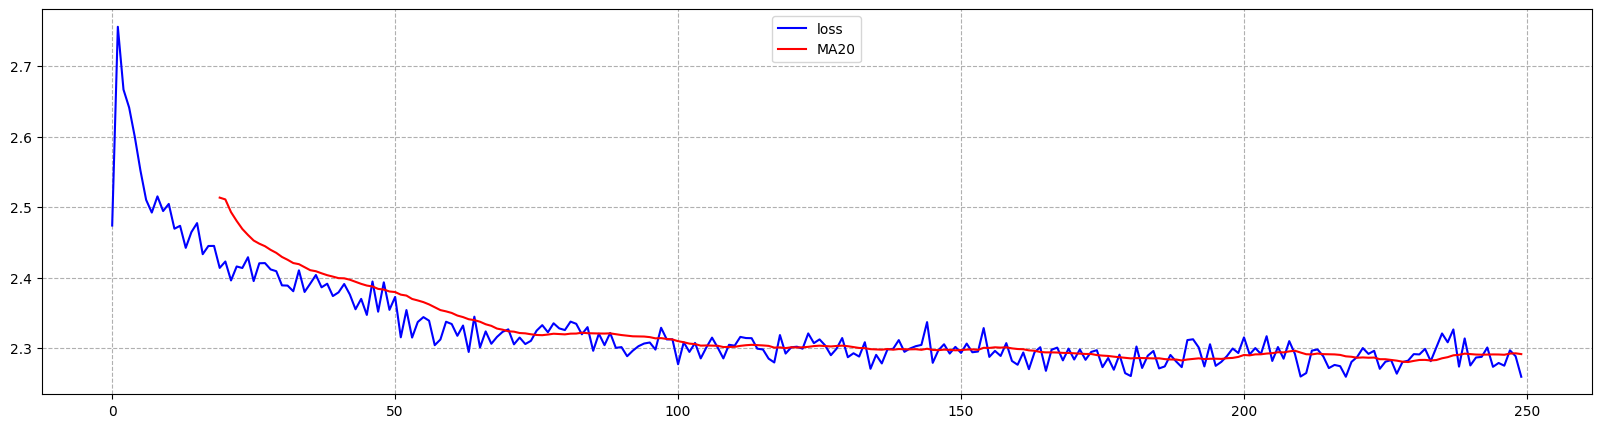

Tail of Moving Average column


240    2.291715
241    2.291045
242    2.290832
243    2.291066
244    2.291209
245    2.291117
246    2.290723
247    2.292380
248    2.292798
249    2.291655
Name: X, dtype: float64

In [218]:
# Plot loss
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(LL, columns=['X'])
X_col=df['X']
MA_X_col = df['X'].rolling(window=20).mean()
plt.figure(figsize=(20, 5))
plt.plot(X_col, 'b-', label='loss')
plt.plot(MA_X_col, 'r-', label='MA20')
plt.grid(linestyle='--')
plt.legend(loc='upper center')
plt.show()
print("Tail of Moving Average column")
MA_X_col[-10:]

In [219]:
s=encode("emm")

for i in range(100):
    x = torch.tensor([s[-att:]], device=device)
    L = forward(x)
    ci = int(torch.argmax(L).item())
    c = itos[ci]
    if ci == 0:
        break
    s += [ci]
print(decode(s))

emmarian


In [220]:
beg = []
batch = words[30:55]
for w in batch:
    if len(w) < att:
        w = "." * (len(w) - att) + w
    beg.append(encode(w[:att]))
x = torch.tensor(beg, device=device)
#print(x)
for i in range(7):
    L = forward(x[:,-att:])
    y = torch.argmax(L, dim=1, keepdim=True)
    x = torch.cat([x,y],dim=-1)
for i, row in enumerate(x.detach().cpu().numpy()):
    print(decode(row, True), "   ", batch[i])


kyma     kymberlynn
parian     parrish
hous     houstyn
jamarian     jamaya
ahmin     ahmod
niva     nivin
milla     milli
crie     cristiana
jaila     jaimee
mita     mitchell
nai     nairah
lor     lorena
gen     gentrie
tor     torrion
savie     savian
ben     benjamine
aira     airess
knue     knute
sulla     sultana
dan     danai
azzin     azzan
iss     issabelle
abrie     abrahim
aish     aislyn
aera     aerys
